<a href="https://colab.research.google.com/github/MihailMV/Fruits-and-vegetables/blob/master/NN_fruits_and_vegetables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import zipfile
import shutil
import numpy as np
from tqdm import tqdm

from PIL import Image

In [0]:
DIR = 'fruits_vegetables'
DIR_TRAIN = 'TRAIN'
DIR_VAL = 'VAL'
DIR_TEST = 'TEST'
IMG_SIZE = (224, 224)
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])
BATCH_SIZE = 10

os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Colab Notebooks/kaggle/" 

In [7]:
!kaggle datasets download -d balalexv/fruits-vegetables-photos
with zipfile.ZipFile('/content/fruits-vegetables-photos.zip', 'r') as zip_obj:
   zip_obj.extractall('/content/')
!rm '/content/fruits-vegetables-photos.zip'

100% 1.80G/1.80G [00:23<00:00, 29.2MB/s]
100% 1.80G/1.80G [00:23<00:00, 83.3MB/s]


In [0]:
shutil.rmtree('fruits_vegetables')

In [8]:
os.makedirs(os.path.join(DIR, DIR_VAL), exist_ok=True)

for class_name in os.listdir(os.path.join(DIR,DIR_TRAIN)):
  os.makedirs(os.path.join(DIR, DIR_VAL, class_name), exist_ok=True)
  cnt_all = 0
  cnt_v = 0
  for i, f in enumerate(os.listdir(os.path.join(DIR,DIR_TRAIN, class_name))):
    cnt_all += 1
    if (np.random.randint(1, 11) == 1):
      shutil.move(os.path.join(DIR,DIR_TRAIN, class_name,f), os.path.join(DIR,DIR_VAL,class_name,f))
      cnt_v += 1
  print(f'{class_name}: VAL = {cnt_v}, ALL = {cnt_all}, PRC = {(cnt_v / cnt_all * 100):.4}')

grapefruit_yellow: VAL = 18, ALL = 202, PRC = 8.911
grape_black: VAL = 20, ALL = 218, PRC = 9.174
cucumber_prickly: VAL = 57, ALL = 611, PRC = 9.329
sultana: VAL = 57, ALL = 549, PRC = 10.38
pepper_red: VAL = 14, ALL = 128, PRC = 10.94
gala: VAL = 24, ALL = 274, PRC = 8.759
pepper_yellow: VAL = 22, ALL = 174, PRC = 12.64
bananas: VAL = 71, ALL = 644, PRC = 11.02
lady_fingers: VAL = 25, ALL = 179, PRC = 13.97
granny_smith: VAL = 43, ALL = 439, PRC = 9.795
tomato_plum: VAL = 46, ALL = 555, PRC = 8.288
lemon: VAL = 77, ALL = 588, PRC = 13.1
golden: VAL = 22, ALL = 227, PRC = 9.692


In [0]:
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import torchvision
import torch
import matplotlib.pyplot as plt

In [0]:
train_transforms = transforms.Compose([
    transforms.RandomPerspective(),
    #transforms.RandomRotation(degrees=45),
    transforms.RandomResizedCrop(size=256, scale=(0.5, 1.0)),
    #transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(size=224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

val_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

train_dataset = torchvision.datasets.ImageFolder(os.path.join(DIR,DIR_TRAIN), train_transforms)
val_dataset = torchvision.datasets.ImageFolder(os.path.join(DIR,DIR_VAL), val_transforms)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)


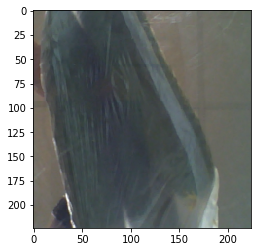

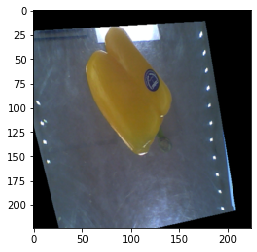

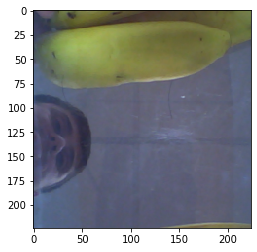

In [26]:
i = 0

for inputs, labels in train_dataloader:
  for img in inputs:
    show_input(img)
    i += 1
  if i >= 3:
    break



In [0]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = STD * image + MEAN
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)


In [0]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
  hist_loss_train = []
  hist_acc_train = []
  hist_loss_val = []
  hist_acc_val = []
  for epoch in range(num_epochs):
    # Train
    running_loss = 0.
    running_acc = 0.
    model.train()
    #for inputs, labels in tqdm(train_dataloader):
    for inputs, labels in train_dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      with torch.set_grad_enabled(True):
        preds = model(inputs)
        loss_value = loss(preds, labels)
        preds_class = preds.argmax(dim=1)
        loss_value.backward()
        optimizer.step()
        running_loss += loss_value.item()
        running_acc += (preds_class == labels.data).float().mean()
        loss_train = running_loss / len(train_dataloader)
        acc_train = running_acc / len(train_dataloader)
    scheduler.step(loss_train)
    # Val
    running_loss = 0.
    running_acc = 0.
    model.eval()
    for inputs, labels in val_dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      with torch.set_grad_enabled(False):
        preds = model(inputs)
        loss_value = loss(preds, labels)
        preds_class = preds.argmax(dim=1)
        running_loss += loss_value.item()
        running_acc += (preds_class == labels.data).float().mean()
        loss_val = running_loss / len(val_dataloader)
        acc_val = running_acc / len(val_dataloader)
    
    print(f'Epoch {epoch}/{num_epochs - 1}: Train: Loss: {loss_train:.4f}, Acc: {acc_train:.4f}   Val: Loss: {loss_val:.4f}, Acc: {acc_val:.4f}', flush=True)
    hist_loss_train.append(loss_train)
    hist_acc_train.append(acc_train.item())
    hist_loss_val.append(loss_val)
    hist_acc_val.append(acc_val.item())

  return model, [hist_loss_train,hist_acc_train,hist_loss_val,hist_acc_val]

In [0]:
cl_cnt = {}
for class_name in os.listdir(os.path.join(DIR,DIR_TRAIN)):
  cl_cnt[class_name] = 0
  for i, f in enumerate(os.listdir(os.path.join(DIR,DIR_TRAIN, class_name))):
    cl_cnt[class_name] += 1

In [29]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, len(train_dataset.classes))

#model.fc = torch.nn.Sequential(
#    torch.nn.Linear(model.fc.in_features, 512),
#    torch.nn.ReLU(),
#    torch.nn.Dropout(0.4),
#    torch.nn.Linear(512, len(train_dataset.classes))
#    , torch.nn.LogSoftmax(dim=1) # For using NLLLoss()
#)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

cl_weight = max([cnt for cnt in cl_cnt.values()]) / torch.tensor([cl_cnt[cl] for cl in train_dataset.classes], dtype=float, device=device)

loss = torch.nn.CrossEntropyLoss(weight=cl_weight.float())
#loss = torch.nn.NLLLoss(weight=cl_weight.float())

optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-2, weight_decay = 0.05, amsgrad=True)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.3, patience=3, threshold= 0.001, verbose=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 256MB/s]


In [0]:
train_dataset.class_to_idx

{'bananas': 0,
 'cucumber_prickly': 1,
 'gala': 2,
 'golden': 3,
 'granny_smith': 4,
 'grape_black': 5,
 'grapefruit_yellow': 6,
 'lady_fingers': 7,
 'lemon': 8,
 'pepper_red': 9,
 'pepper_yellow': 10,
 'sultana': 11,
 'tomato_plum': 12}

In [30]:
cl_weight.float()

tensor([1.0000, 1.0343, 2.2920, 2.7951, 1.4470, 2.8939, 3.1141, 3.7208, 1.1213,
        5.0263, 3.7697, 1.1646, 1.1257], device='cuda:0')

In [31]:
model, hist = train_model(model, loss, optimizer, scheduler, num_epochs=30);

Epoch 0/29: Train: Loss: 6.3787, Acc: 0.2715   Val: Loss: 4.4895, Acc: 0.4217
Epoch 1/29: Train: Loss: 6.2266, Acc: 0.2770   Val: Loss: 3.9091, Acc: 0.3233
Epoch 2/29: Train: Loss: 6.3616, Acc: 0.2781   Val: Loss: 7.5001, Acc: 0.1948
Epoch 3/29: Train: Loss: 6.2483, Acc: 0.2930   Val: Loss: 5.8016, Acc: 0.3775
Epoch 4/29: Train: Loss: 6.1463, Acc: 0.2837   Val: Loss: 3.6537, Acc: 0.4277
Epoch 5/29: Train: Loss: 6.2328, Acc: 0.2837   Val: Loss: 3.3748, Acc: 0.6104
Epoch 6/29: Train: Loss: 6.6413, Acc: 0.2724   Val: Loss: 1.6508, Acc: 0.5562
Epoch 7/29: Train: Loss: 5.9154, Acc: 0.2996   Val: Loss: 6.0646, Acc: 0.4016
Epoch 8/29: Train: Loss: 5.9014, Acc: 0.2972   Val: Loss: 5.6722, Acc: 0.4839
Epoch 9/29: Train: Loss: 6.1670, Acc: 0.2994   Val: Loss: 1.8963, Acc: 0.6426
Epoch 10/29: Train: Loss: 6.0397, Acc: 0.2888   Val: Loss: 6.6361, Acc: 0.3012
Epoch 11/29: Train: Loss: 5.9640, Acc: 0.2895   Val: Loss: 3.4746, Acc: 0.5924
Epoch 12/29: Train: Loss: 5.8095, Acc: 0.2872   Val: Loss: 3.3

KeyboardInterrupt: ignored

In [0]:
model, hist = train_model(model, loss, optimizer, scheduler, num_epochs=22);

Epoch 0/21: Train: Loss: 0.7361, Acc: 0.8595   Val: Loss: 0.6947, Acc: 0.8939
Epoch 1/21: Train: Loss: 0.7489, Acc: 0.8555   Val: Loss: 0.7122, Acc: 0.8708
Epoch    54: reducing learning rate of group 0 to 8.1000e-05.
Epoch 2/21: Train: Loss: 0.7317, Acc: 0.8583   Val: Loss: 0.6639, Acc: 0.8993
Epoch 3/21: Train: Loss: 0.7218, Acc: 0.8714   Val: Loss: 0.6846, Acc: 0.8983
Epoch 4/21: Train: Loss: 0.7260, Acc: 0.8667   Val: Loss: 0.6756, Acc: 0.9061
Epoch 5/21: Train: Loss: 0.7359, Acc: 0.8738   Val: Loss: 0.6783, Acc: 0.9028
Epoch 6/21: Train: Loss: 0.7269, Acc: 0.8738   Val: Loss: 0.6863, Acc: 0.9019
Epoch 7/21: Train: Loss: 0.7161, Acc: 0.8765   Val: Loss: 0.6698, Acc: 0.9050
Epoch 8/21: Train: Loss: 0.7185, Acc: 0.8780   Val: Loss: 0.6920, Acc: 0.8939
Epoch 9/21: Train: Loss: 0.7166, Acc: 0.8697   Val: Loss: 0.6870, Acc: 0.8985
Epoch 10/21: Train: Loss: 0.7161, Acc: 0.8828   Val: Loss: 0.6908, Acc: 0.8930
Epoch    63: reducing learning rate of group 0 to 2.4300e-05.
Epoch 11/21: Trai

In [0]:
plt.plot(hist[0][0:10])
plt.plot(hist[2][0:10])
plt.show()

plt.plot(hist[1][0:10])
plt.plot(hist[3][0:10])
plt.show()


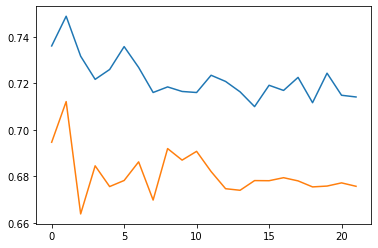

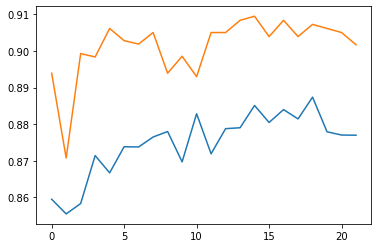

In [0]:
plt.plot(hist[0][0:])
plt.plot(hist[2][0:])
plt.show()

plt.plot(hist[1][0:])
plt.plot(hist[3][0:])
plt.show()


In [0]:
test_dataset = torchvision.datasets.ImageFolder(os.path.join(DIR,DIR_TEST), val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=117, shuffle=False, num_workers=8)

In [0]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 117
    Root location: fruits_vegetables/TEST
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
           )

In [0]:
model.eval()

test_predictions = []
test_img_paths = []

running_loss = 0.
running_acc = 0.

for inputs, labels in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
        preds_class = preds.argmax(dim=1)
        running_acc += (preds_class == labels.data).float().sum().cpu()

print(running_acc / 117, 117 - running_acc)

100%|██████████| 1/1 [00:01<00:00,  1.71s/it]

tensor(0.7863) tensor(25.)


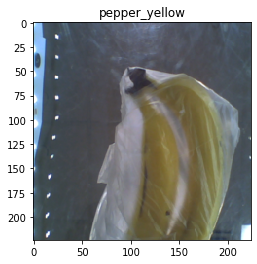

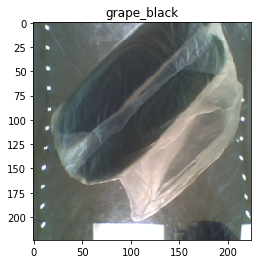

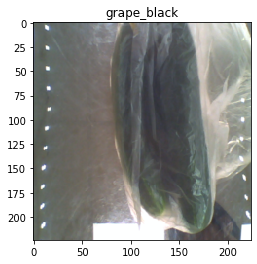

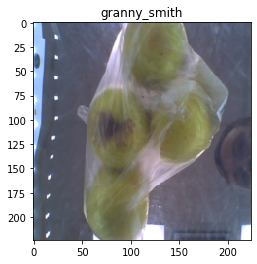

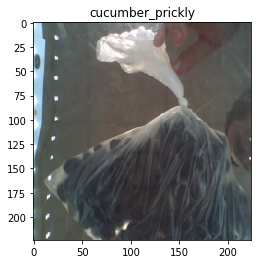

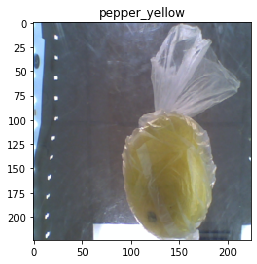

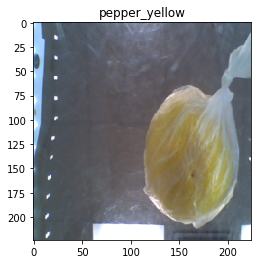

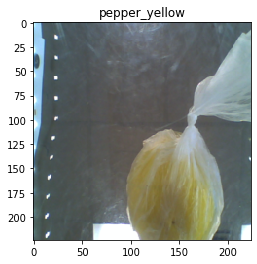

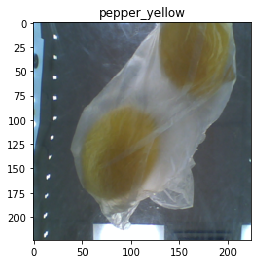

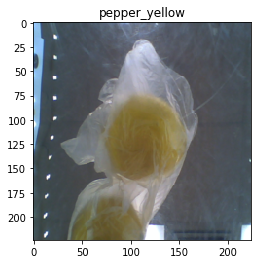

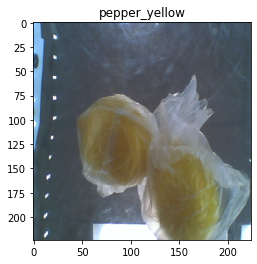

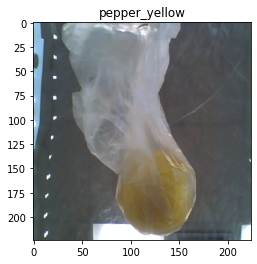

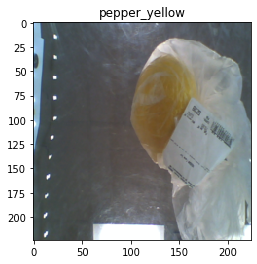

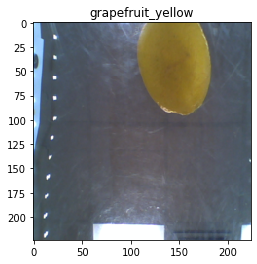

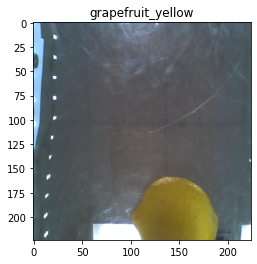

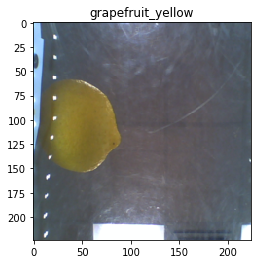

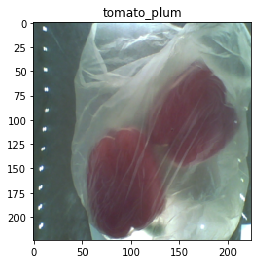

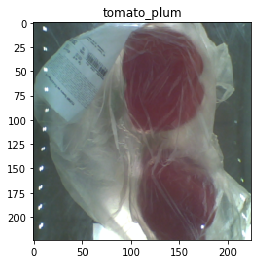

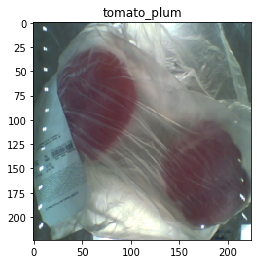

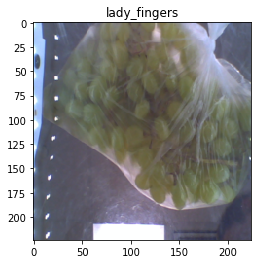

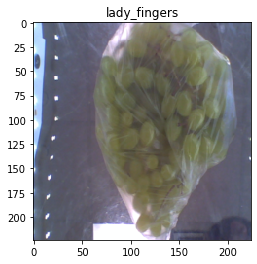

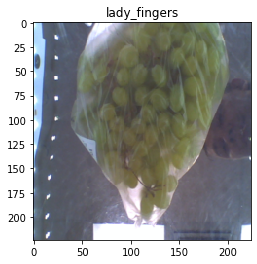

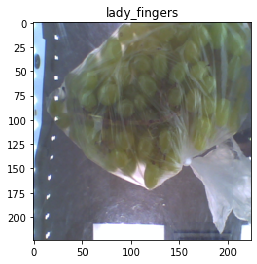

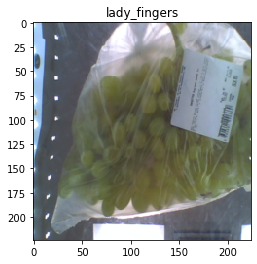

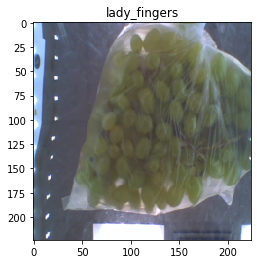

In [0]:
for i in range(inputs.size()[0]):
  if (preds_class[i] != labels.data[i]):
    show_input(inputs[i].cpu(), train_dataset.classes[preds_class[i]])


In [0]:
inputs.size()[0]

117

In [0]:
running_acc / 117, 117 - running_acc

(tensor(0.8462), tensor(18.))

In [0]:
running_acc / 117, 117 - running_acc

(tensor(0.7863), tensor(25.))

In [0]:
(117-9)/117

0.9230769230769231

In [0]:
for img inputs
        show_input(inputs)


In [0]:
model.